In [6]:
import sys
sys.path.insert(0, "../")
from tmds import *
import os
%matplotlib inline

In [7]:
from sklearn.preprocessing import StandardScaler as SS
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.utils import resample
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder

In [8]:
s = ["CHA", "SFA-Ctk", "SFA-Pw", "SHA-Ctk", "SHA-Pw", "SRHA"]
cities = ["a", "b", "c", "d", "e"]

In [9]:
df = pd.read_csv("data.csv", "\t")
df["abundance"] = np.log(df["abundance"])
df["H/C"] = df["H"] / df["C"]
df["O/C"] = df["O"] / df["C"]
df["DBE"] = df["C"] - df["H"]/2 + df["N"]/2 + 1
df.sample(10)

,exp,town,abundance,mw,error,C,H,O,N,S,y,H/C,O/C,DBE
105265,SHA-Pw,d,-5.962968,658.444726,0.389741,39,62,8,0,0,2,1.589744,0.205128,9.0
118692,SRHA,a,-4.661110,398.233836,0.025992,18,38,7,0,1,2,2.111111,0.388889,0.0
17021,CHA,e,-4.230583,518.288216,0.477269,29,42,8,0,0,3,1.448276,0.275862,9.0
136971,SRHA,e,-3.679604,325.022236,-0.048341,16,7,7,1,0,2,0.437500,0.437500,14.0
7454,CHA,b,-5.718601,482.230476,0.046241,28,34,7,0,0,4,1.214286,0.250000,12.0
111772,SHA-Pw,e,-4.616594,595.053716,-0.386274,34,13,10,1,0,1,0.382353,0.294118,29.0
124178,SRHA,b,-5.161401,409.079766,-0.001584,21,15,8,1,0,4,0.714286,0.380952,15.0
31280,SFA-Ctk,a,-5.231555,602.033246,-0.039999,29,14,15,0,0,3,0.482759,0.517241,23.0
880,CHA,a,-5.977087,364.079436,0.010121,17,16,9,0,0,2,0.941176,0.529412,10.0
134191,SRHA,d,-4.226150,469.994496,0.240060,21,10,11,0,1,1,0.476190,0.523810,17.0


In [10]:
db = pd.get_dummies(df[["town", "abundance", "H/C", "O/C", "N", "S", "DBE", "mw", "error", "y"]])
db["exp"] = df["exp"]
db["y"] = (db["y"] >= 2) * 1
db["town"] = df["town"]
db.sample(5)

,abundance,H/C,O/C,N,S,DBE,mw,error,y,town_a,town_b,town_c,town_d,town_e,exp,town
77478,-4.020150,1.214286,0.428571,1,0,7.0,295.105606,0.062886,1,0,0,0,0,1,SFA-Pw,e
112120,-4.057039,0.571429,0.321429,2,0,22.0,524.085326,-0.485293,0,0,0,0,0,1,SHA-Pw,e
82345,-6.363408,0.857143,0.857143,0,0,5.0,186.016436,-0.010886,0,1,0,0,0,0,SHA-Ctk,a
37865,-2.260800,1.058824,0.352941,0,0,9.0,318.110346,0.023674,1,0,0,0,1,0,SFA-Ctk,d
102210,-3.907045,0.354839,0.032258,1,1,27.0,445.056096,-0.089472,1,0,0,1,0,0,SHA-Pw,c


In [11]:
len(db)

138385

In [12]:
db.exp.unique()
#['CHA', 'SFA-Ctk', 'SFA-Pw', 'SHA-Ctk', 'SHA-Pw', 'SRHA']
#I will not use CHA, SHA-Ctk
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
model = Pipeline([("ss", SS()), ("svm", LR())])

ans = []

for i in range(4):
    train = filter(lambda x: x != exps[i], exps)
    train = pd.concat(list(map(lambda x: db[db["exp"] == x], train)))
    
    one = train[train["y"] == 1]
    zer = train[train["y"] == 0]
    print(len(one))
    print(len(zer))
    tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
    
    
    test = db[db["exp"] == exps[i]]
    
    print "fitting..."
    model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    print "scoring..."
    print exps[i]
    
    ans.append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
    print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
    print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
    print "test:            ", f1_score(ans[-1], test["y"])
    
    
    

59262
16050
fitting...
scoring...
SFA-Ctk
balanced train:   0.80854355069
unbalanced train: 0.866701287342
test:             0.887826973163
58944
14172
fitting...
scoring...
SFA-Pw
balanced train:   0.790971071203
unbalanced train: 0.856453000546
test:             0.842155596997
65421
15765
fitting...
scoring...
SHA-Pw
balanced train:   0.814040351236
unbalanced train: 0.878853562577
test:             0.741971658681
63648
17502
fitting...
scoring...
SRHA
balanced train:   0.813343559495
unbalanced train: 0.870175023052
test:             0.89715380405


In [14]:
db["y_pred"] = 0
for i in range(4):
    db.loc[db["exp"] == exps[i], "y_pred"] = ans[i]

In [15]:
data_1 = []
for i in range(4):
    data_1.append([])
    for j in range(5):
        data_1[-1].append(get_set_of_tuples_from_np(df[(df["exp"] == exps[i]) & (db["y"] == 1) & (df["town"] == cities[j])][elems].values))

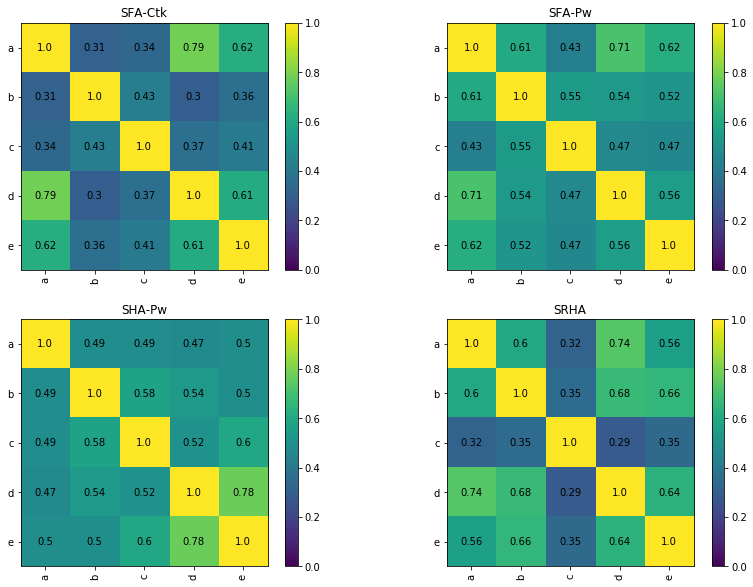

In [16]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_1[e][i], data_1[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [17]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

In [18]:
data = []
for i in range(4):
    data.append([])
    for j in range(5):
        data[-1].append(get_set_of_tuples_from_np(df[(df["exp"] == exps[i]) & 
                                                             (df["town"] == cities[j]) & 
                                                             (df["y"] > 0)][elems].values))

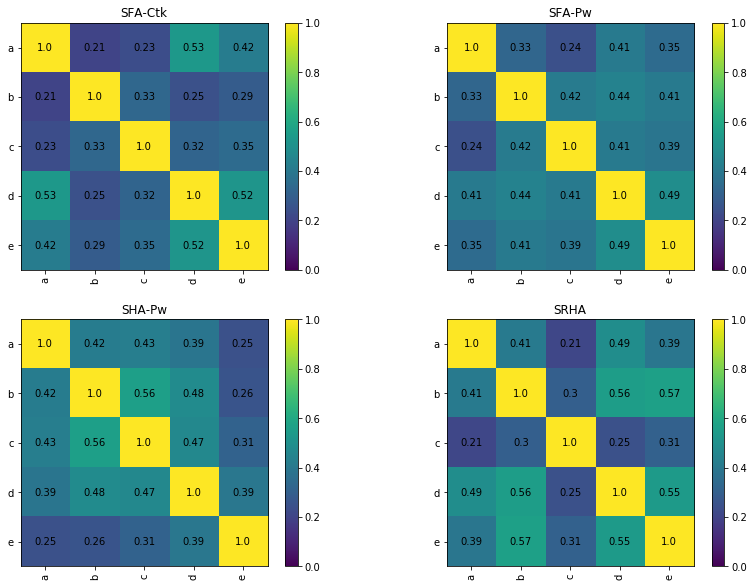

In [19]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data[e][i], data[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

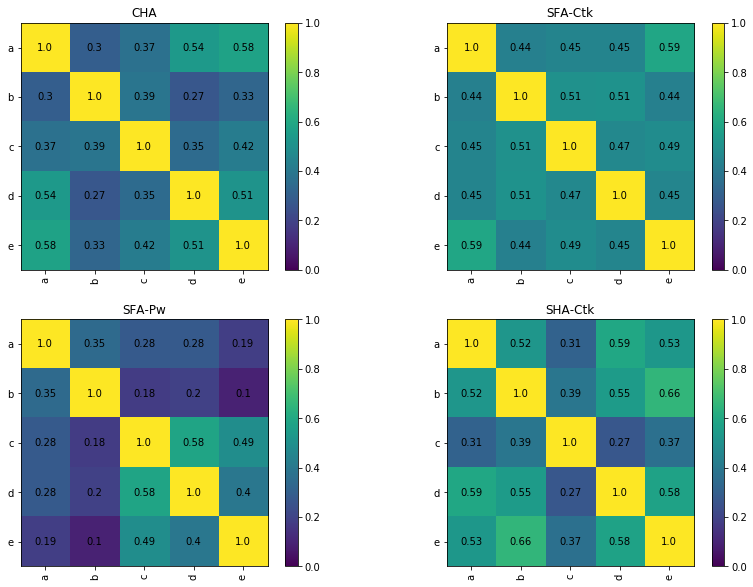

In [20]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(s[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [21]:
models = []
ans = []
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
for t in range(5):
    model = Pipeline([("ss", SS()), ("svm", LR())])
    ans.append([])
    for i in range(4):
        train = filter(lambda x: x != exps[i], exps)
        k = map(lambda x: db[(db["exp"] == x) & (db["town"] == cities[t])], train)
        train = pd.concat(k)

        test = db[(db["exp"] == exps[i]) & (db["town"] == cities[t])]
    
        one = train[train["y"] == 1]
        zer = train[train["y"] == 0]
        print(len(one))
        print(len(zer))
        tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
        model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    
    
        ans[-1].append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
        print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
        print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
        print "test:            ", f1_score(ans[-1][-1], test["y"])

13310
7236
balanced train:   0.841100335836
unbalanced train: 0.871656499296
test:             0.857664233577
13481
5364
balanced train:   0.82173317088
unbalanced train: 0.861041292639
test:             0.756829291671
17005
9467
balanced train:   0.837460656809
unbalanced train: 0.865551634188
test:             0.853533359653
15364
7963
balanced train:   0.834689239485
unbalanced train: 0.866600553979
test:             0.891474508145
11101
1590
balanced train:   0.816130999042
unbalanced train: 0.900139295836
test:             0.888173427774
9210
1373
balanced train:   0.813716791064
unbalanced train: 0.900427399792
test:             0.891628020503
10977
2307
balanced train:   0.839516129032
unbalanced train: 0.902340364057
test:             0.729176814418
9452
1846
balanced train:   0.875632160182
unbalanced train: 0.931284302964
test:             0.880437484464
7659
666
balanced train:   0.897524205601
unbalanced train: 0.943635990982
test:             0.976727004064
7202
436
balanc

In [22]:
db["y_pred"] = 0
for i in range(4):
    for t in range(5):
        db.loc[(db["exp"] == exps[i]) & (db["town"] == cities[t]), "y_pred"] = ans[t][i]

In [23]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

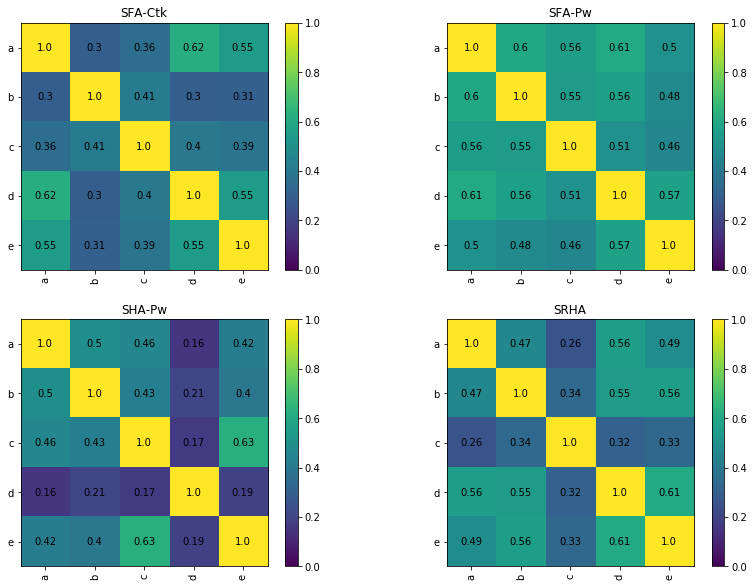

In [24]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})

In [24]:
models = []
ans = []
exps = ['SFA-Ctk', 'SFA-Pw', 'SHA-Pw', 'SRHA']
for t in range(5):
    model = Pipeline([("ss", SS()), ("svm", SVC())])
    ans.append([])
    for i in range(4):
        train = filter(lambda x: x != exps[i], exps)
        k = map(lambda x: db[(db["exp"] == x) & (db["town"] == cities[t])], train)
        train = pd.concat(k)

        test = db[(db["exp"] == exps[i]) & (db["town"] == cities[t])]
    
        one = train[train["y"] == 1]
        zer = train[train["y"] == 0]
        print(len(one))
        print(len(zer))
        tr = pd.concat([one, resample(zer, n_samples=len(one), random_state=42)])
        model.fit(tr.drop(["y", "exp", "town"], axis=1), tr["y"])
    
    
        ans[-1].append(model.predict(test.drop(["y", "exp", "town"], axis=1)))
    
    
        print "balanced train:  ", f1_score(model.predict(tr.drop(["y", "exp", "town"], axis=1)), tr["y"])
        print "unbalanced train:", f1_score(model.predict(train.drop(["y", "exp", "town"], axis=1)), train["y"])
        print "test:            ", f1_score(ans[-1][-1], test["y"])

10186
10360
balanced train:   0.887898459452
unbalanced train: 0.885367856625
test:             0.821057288211
10102
8743
balanced train:   0.873649738501
unbalanced train: 0.881491344874
test:             0.785290915689
12276
14196
balanced train:   0.886101314524
unbalanced train: 0.874051233397
test:             0.77416481069
11203
12124
balanced train:   0.875965627984
unbalanced train: 0.868801652893
test:             0.821690140845
9784
2907
balanced train:   0.886086591005
unbalanced train: 0.913641781341
test:             0.884700122399
8229
2354
balanced train:   0.890403251016
unbalanced train: 0.916532595405
test:             0.928126621692
9573
3711
balanced train:   0.893252183117
unbalanced train: 0.919331118253
test:             0.4540302267
8465
2833
balanced train:   0.909865656625
unbalanced train: 0.936867763559
test:             0.732213951878
7111
1214
balanced train:   0.911610540676
unbalanced train: 0.937873975031
test:             0.951282561145
6682
956
balanc

In [25]:
db["y_pred"] = 0
for i in range(4):
    for t in range(5):
        db.loc[(db["exp"] == exps[i]) & (db["town"] == cities[t]), "y_pred"] = ans[t][i]

In [26]:
data_m = []
for i in range(4):
    data_m.append([])
    for j in range(5):
        tmp = db.copy()
        tmp["town"] = df["town"]
        for e in elems:
            tmp[e] = df[e]
        tmp = tmp[tmp["y_pred"] == 1]
        tmp = tmp[(tmp["exp"] == exps[i]) & (tmp["town"] == cities[j])]
        
        data_m[-1].append(get_set_of_tuples_from_np(tmp[elems].copy().values))

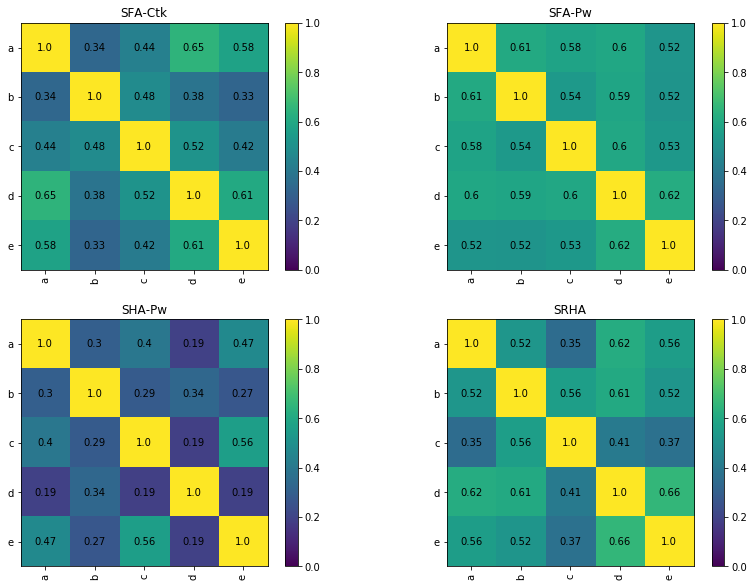

In [27]:
plt.figure(figsize=(14, 10))
for e in range(4):
    plt.subplot(221 + e)
    plt.title(exps[e])
    corr = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            corr[i][j] = Jaccard_Needham(data_m[e][i], data_m[e][j])
    plt.imshow(corr, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.yticks(range(5), cities)
    plt.xticks(range(5), cities, rotation="vertical")
    for i in range(5):
        for j in range(5):
            plt.text(i, j, np.round(corr[i][j], 2), {'ha': 'center', 'va': 'center'})